# The variational quantum eigensolver (VQE)

This lesson will introduce the variational quantum eigensolver, explain its importance as a foundational algorithm in quantum computing, and also explore its strengths and weaknesses. VQE by itself, without augmenting methods, is not likely to be sufficient for modern utility scale quantum computations. It is nevertheless important as an archetypal classical-quantum hybrid method, an it is an important foundation upon which many more advanced algorithms are built.

## 1. What is VQE?

The variational quantum eigensolver is an algorithm that uses classical and quantum computing in conjunction to accomplish a task. There are 4 main components of a VQE calculation:

*   **An operator**: Often a Hamiltonian, which we’ll call $H$, that describes a property of your system that you wish to optimize. Another way of saying this is that you are seeking the eigenvector of this operator that corresponds to the minimum eigenvalue. We often call that eigenvector the “ground state”.
*   **An “ansatz”** (a German word meaning “approach”): this is a quantum circuit that prepares a quantum state approximating the eigenvector you’re seeking. Really the ansatz is a family of quantum circuits, because some of the gates in the ansatz are parametrized, that is, they are fed a parameter which we can vary. This family of quantum circuits can prepare a family of quantum states approximating the ground state.
*   **An estimator**: a means of estimating the expectation value of the operator $H$  over the current variational quantum state. Sometimes what we really care about is simply this expectation value, which we call a cost function. Sometimes, we care about a more complicated function that can still be written starting from one or more expectation values.
*   **A classical optimizer**: an algorithm that varies parameters to try to minimize the cost function.

Let's look at each of these components in more depth.

### 1.1 The operator (Hamiltonian)

At the core of a VQE problem is an operator that describes a system of interest. We will assume here that the lowest eigenvalue and the corresponding eigenvector of this operator are useful for some scientific or business purpose. Examples might include a chemical Hamiltonian describing a molecule, such that the lowest eigenvalue of the operator corresponds to the ground state energy of the molecule, and the corresponding eigenstate describes the geometry or electron configuration of the molecule. Or the operator could describe a cost of a certain process to be optimized, and the eigenstates could correspond to routes or practices. In some fields, like physics, a "Hamiltonian" almost always refers to an operator describing the energy of a physical system. But in quantum computing, it is common to see quantum operators that describe a business or logistical problem also referred to as a "Hamiltonian". We will adopt that convention here.

Mapping a physical or optimization problem to qubits is typically a non-trivial task, but those details are not the focus of this course. A general discussion of mapping a problem to a quantum operator can be found in [Quantum computing in practice](/learning/courses/quantum-computing-in-practice). A more detailed look at the mapping of chemistry problems into quantum operators can be found in [Quantum Chemistry with VQE](/learning/courses/quantum-chem-with-vqe).

### 1.3 Estimator

We need a way to estimate the expectation value of our Hamiltonian in a particular variational state $|\psi(\vec{\theta})\rangle$. If we could directly measure the entire operator $H$, this would be as simple as making many (say $N$) measurements and averaging the measured values:

$$
\langle \psi(\vec{\theta})|H|\psi(\vec{\theta})\rangle _N \approx \frac{1}{N}\sum_{j=1}^N {E_j}
$$

Here, the $\approx$ symbol reminds us that this expectation value would only be precisely correct in the limit as $N\rightarrow \infty$. But with thousands of measurements being made on a circuit, the sampling error of the expectation value is fairly low. There are other considerations such as noise that become an issue for very precise calculations.

However, it is generally not possible to measure $H$ all at once. $H$ may contain multiple non-commuting Pauli X, Y, and Z operators. So the Hamiltonian must be broken up into groups of operators that can be simultaneously measured, and each such group must be estimated separately, and the results combined to obtain an expectation value. We will revisit this in greater detail in the next lesson, when we discuss the scaling of classical and quantum approaches. This complexity in measurement is one reason we need highly efficient code for carrying out such estimation. In this lesson and beyond, we will use the Qiskit Runtime primitive Estimator for this purpose.

### 1.4 Classical optimizers

A classical optimizer is any classical algorithm designed to find extrema of a target function (typically a minimum). They search through the space of possible parameters looking for a set that minimizes some function of interest. They can be broadly categorized into gradient-based methods, which utilize gradient information, and gradient-free methods, which operate as black-box optimizers. The choice of classical optimizer can significantly impact an algorithm's performance, especially in the presence of noise in quantum hardware. Popular optimizers in this field include Adam, AMSGrad, and SPSA, which have shown promising results in noisy environments. More traditional optimizers include COBYLA and SLSQP.

A common workflow (demonstrated in Section 3.3) is to use one of these algorithms as the method inside a minimizer like scipy's `minimize` function. This takes as its arguments:

*   Some function to be minimized. This is often the energy expectation value. But these are generally referred to as "cost functions".
*   A set of parameters from which to begin the search. Often called $x_0$ or $\theta_0$.
*   Arguments, including arguments of the cost function. In quantum computing with Qiskit, these arguments will include the ansatz, the Hamiltonian, and the estimator, which is discussed more in the next subsection.
*   A 'method' of minimization. This refers to the specific algorithm used to search the parameter space. This is where we would specify, for example, COBYLA or SLSQP.
*   Options. The options available may differ by method. But an example which practically all methods would include is the maximum number of iterations of the optimizer before ending the search: 'maxiter'.

At each iterative step, the expectation value of the Hamiltonian is estimated by making many measurements. This estimated energy is returned by the cost function, and the minimizer updates the information it has about the energy landscape. Exactly what the optimizer does to choose the next step varies from method to method. Some use gradients and select the direction of steepest descent. Others may take noise into account and may require that the cost decrease by a large margin before accepting that the true energy decreases along that direction.

### 1.5 The variational principle

In this context the variational principle is very important; it states that no variational wave function can yield an energy (or cost) expectation value lower than that yielded by the ground state wave function. Mathematically,

$$
E_\text{var}=\langle \psi_\text{var}|H|\psi_\text{var}\rangle \geq E_\text{min}=\langle \psi_\text{0}|H|\psi_\text{0}\rangle
$$

This is easy to verify if we note that the set of all eigenstates $\{|\psi_0\rangle, |\psi_1\rangle, |\psi_2\rangle, ...|\psi_n \rangle\}$ of $H$ form a complete basis for the Hilbert space. In other words, any state and in particular $|\psi_\text{var}\rangle$ can be written as a weighted (normalized) sum of these eigenstates of $H$:

$$
|\psi_\text{var}\rangle=\sum_{i=0}^n c_i |\psi_i\rangle
$$

where $c_i$ are constants to be determined, and $\sum_{i=0} |c_i|^2 = 1$. We leave this as an exercise to the reader. But note the implication: the variational state that produces the lowest-energy expectation value *is* the best estimate of the true ground state.

## 2. Comparison with classical workflow

Let’s say we are interested in a matrix with N rows and N columns. Suppose your matrix is so large that exact diagonalization is not an option. Suppose further that you know enough about your problem that you can make some guesses about the overall structure of the target eigenstate, and you want to probe states similar to your initial guess to see if your cost/energy can be lowered further. This is a variational approach, and it is one method that is used when exact diagonalization is not an option.

### 2.1 Classical workflow

Using a classical computer, this would work as follows:

*   Make a guess state, with some parameters $\vec{\theta}_i$ that you will vary: $|\psi(\vec{\theta}_i)\rangle$. Although this initial guess could be random, that is not advisable. We want to use knowledge of the problem at hand to tailor our guess as much as possible.
*   Calculate the expectation value of the operator with the system in that state: $\langle\psi(\vec{\theta}_i)|H|\psi(\vec{\theta}_i)\rangle$
*   Alter the variational parameters and repeat: $\vec{\theta}_i\rightarrow \vec{\theta}_{i+1}$.
*   Use accumulated information about the landscape of possible states in your variational subspace to make better and better guesses and approach the target state. The variational principle guarantees that our variational state cannot yield an eigenvalue lower than that of the target ground state. So the lower the expectation value the better our approximation of the ground state:

$$
\min_{\vec{\theta}} \{ E_{\text{var},i} = \langle\psi(\vec{\theta_i})|H|\psi(\vec{\theta_i})\rangle \} \geq E_0
$$

Let us examine the difficulty of each step in this approach. Setting or updating parameters is computationally easy; the difficulty there is in selecting useful, physically motivated initial parameters. Using accumulated information from prior iterations to update parameters in such a way that you approach the ground state is a non-trivial. But classical optimization algorithms exist that do this quite efficiently. This classical optimization is only expensive because it may require many iterations; in the worst case, the number of iterations may scale exponentially with N. The most computationally expensive single step is almost certainly calculating the expectation value of your matrix using a given state $|\psi(\vec{\theta_i})\rangle$: $\langle\psi(\vec{\theta_i})|H|\psi(\vec{\theta_i})\rangle.$

The $N\times N$ matrix must act on the $N$-element vector, which corresponds to: $O(N^2)$ multiplication operations in the worst case. This must be done at each iteration of parameters. For extremely large matrices, this has high computational cost.

### 2.2 Quantum workflow and commuting Pauli groups

Now imagine relegating this portion of the calculation to a quantum computer. Instead of calculating this expectation value, you estimate it by preparing the state $|\psi(\vec{\theta_i})\rangle$ on the quantum computer using your variational ansatz, and then making measurements.

That may sound easier than it is. $H$ is generally not easy to measure. For example it could be made up of many non-commuting Pauli X, Y, and Z operators. But $H$ **can** be written as a linear combination of terms, $h_\alpha$, each of which is easily measurable (for example, Pauli operators or groups of qubit-wise commuting Pauli operators).
The expectation value of $H$ over some state $|\Psi\rangle$ is the weighted sum of expectation values of the constituent  terms $h_\alpha$. This expression holds for any state $|\Psi⟩$, but we will specifically be using this with our variational states $|\psi(\theta_i)\rangle$.

$$
H = \sum_{\alpha = 1}^T{c_\alpha h_\alpha}
$$

where $h_\alpha$ is a Pauli string like `IZZX…XIYX`, or several such strings that commute with each other. So a description of the expectation value that more closely matches the realities of measurement on quantum computers is

$$
\langle \Psi |H|\Psi \rangle =\sum_{\alpha} c_\alpha \langle \Psi | h_\alpha|\Psi \rangle.
$$

And in the context of our variational wave function:

$$
\langle \psi(\vec{\theta}_i) |H|\psi(\vec{\theta}_i) \rangle =\sum_{\alpha} c_\alpha \langle \psi(\vec{\theta}_i) | h_\alpha|\psi(\vec{\theta}_i) \rangle
$$

Each of the terms $h_\alpha$ can be measured $M$ times yielding measurement samples $s_{\alpha j}$ with $j=1…M$ and returns an expectation value $\mu_\alpha$ and a standard deviation $\sigma_\alpha$. We can sum these terms and propagate errors through the sum to obtain an overall expectation value $\mu$ and standard deviation $\sigma$.

$$
\begin{aligned}
\langle \psi(\vec{\theta}_i) |h_\alpha|\psi(\vec{\theta}_i) \rangle &\simeq \mu _\alpha \pm \frac{\sigma_\alpha}{\sqrt{M}} &\qquad \mu_\alpha &=\frac{1}{M}\sum_j s_{\alpha,j} &\qquad \sigma^2_\alpha &=\frac{1}{M-1}\sum_j (s_{\alpha,j}-\mu_\alpha)^2\\

\langle \psi(\vec{\theta}_i) |H|\psi(\vec{\theta}_i) \rangle &\simeq \mu  \pm \sigma &\qquad \mu &= \sum_\alpha c_\alpha \mu_\alpha &\qquad \sigma^2&=\sum_\alpha c^2_\alpha \frac{\sigma^2_\alpha }{M}

\end{aligned}
$$

This requires no large-scale multiplication, nor any process that necessarily scales like $N^2$. Instead it requires multiple measurements on the quantum computer. If you don’t need too many of those, this approach could be efficient. And that’s the quantum part of VQE.

But let’s talk about reasons why this might not be efficient. One reason for many measurements is to reduce the statistical uncertainty in your estimates, for very high-precision calculations. Another reason is the number of Pauli strings required to span your entire matrix. Because Pauli matrices (plus the identity: X, Y, Z, and I) span the space of all operators of a given dimension, we are guaranteed that we can write our matrix of interest as a weighted sum of Pauli operators, as we did before.

$$
H = \sum_{\alpha = 1}^T{c_\alpha h_\alpha}
$$

where $h_\alpha$ is a Pauli string acting on all the qubits describing your system like `IZZX…XIYX`, or several such strings that commute with each other. Recall that Qiskit uses *little endian* notation, in which the $n^\text{th}$ Pauli operator from the right acts on the $n^\text{th}$ qubit. So we can measure our operator by measuring a series of Pauli operators.

But we cannot measure all those Pauli operators simultaneously. Pauli operators (excluding I) do not commute with each other if they are associated with the same qubit. For example, we can measure `IZIZ` and `ZZXZ` simultaneously, because we can measure I and Z simultaneously for the 3rd qubit, and we can know I and X simultaneously for the 1st qubit. But we cannot measure ZZZZ and ZZZX simultaneously, because Z and X do not commute, and both act on the 0th qubit.

So we decompose our matrix $H$ into a sum of Paulis acting on different qubits. Some elements of that sum can be measured all at once; we call this a *group of commuting Paulis*. Depending on how many non-commuting terms there are, we may need many such groups. Call the number of such groups of commuting Pauli strings $N_\text{GCP}$. If $N_\text{GCP}$ is small, this could work well. If $H$ has millions of groups, this will not be useful.

The processes required for estimation of the expectation value are collected together in the Qiskit Runtime primitive called Estimator. To learn more about Estimator, see the [API reference](/docs/api/qiskit-ibm-runtime/estimator-v2) in IBM Quantum® Documentation. One can simply use Estimator directly, but Estimator returns much more than just the lowest energy eigenvalue. For example, it also returns information on ensemble standard error. Thus, in the context of minimization problems, one often sees Estimator inside a cost function. To learn more about Estimator inputs and outputs see this [guide](/docs/guides/primitive-input-output) on IBM Quantum Documentation.

You record the expectation value (or the cost function) for the set of parameters $\vec{\theta_i}$ used in your state, and then you update the parameters. Over time, you could use the expectation values or cost-function values you’ve estimated to approximate a gradient of your cost function in the subspace of states sampled by your ansatz. Both gradient-based, and gradient-free classical optimizers exist. Both suffer from potential trainability issues, like multiple local minima, and large regions of parameter space with near-zero gradient, called *barren plateaus*.

### 2.3 Factors that determine computational cost

VQE will not solve all your toughest quantum chemistry problems. No. But being better at all calculations is not the point. We have shifted what determines the computational cost.

We’ve shifted from a process whose complexity depends only on matrix dimension to one that depends on required precision and the number of non-commuting Pauli operators that make up the matrix. The last bit has no analog in classical computing.

Based on these dependencies, for sparse matrices, or matrices involving few non-commuting Pauli strings, this process may be useful. This is the case for systems of interacting spins, for example. For dense matrices, it may be less useful.

## 3. Example Hamiltonian

Let us put this algorithm into practice using a small Hamiltonian matrix so that we can see what is happening in each step. We will employ the Qiskit patterns framework:

-**Step 1**: Map problem to quantum circuits and operators
-**Step 2**: Optimize for target hardware
-**Step 3**: Execute on target hardware
-**Step 4**: Post-process results

### 3.1 Step 1: Map the problem to quantum circuits and operators

We will use the one defined above from the chemistry context. We start with some general imports.

In [16]:
# General imports
!pip install qiskit
from qiskit import QuantumCircuit
!pip install 'qiskit[visualization]'
!pip install qiskit-ibm-runtime
!pip install qiskit_aer
!pip install pylatexenc
import numpy as np

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 95.1 MB/s eta 0:00:00


Again, we assume the Hamiltonian of interest is known. We will use an extremely small Hamiltonian here, because other methods discussed in this course will be more efficient at solving larger problems.

In [9]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

A = np.array(hamiltonian)
eigenvalues, eigenvectors = np.linalg.eigh(A)
print("The ground state energy is ", min(eigenvalues))

The ground state energy is  -0.702930394459531


In [10]:
hamiltonian = SparsePauliOp.from_list(
    [("II", 0.5), ("XX", 0.5), ("YY", 0.5), ("ZZ", 0.5)]
)

hamiltonian = SparsePauliOp(
    [
        "IIII",
        "IIIZ",
        "IZII",
        "IIZI",
        "ZIII",
        "IZIZ",
        "IIZZ",
        "ZIIZ",
        "IZZI",
        "ZZII",
        "ZIZI",
        "YYYY",
        "XXYY",
        "YYXX",
        "XXXX",
    ],
    coeffs=[
        -0.09820182 + 0.0j,
        -0.1740751 + 0.0j,
        -0.1740751 + 0.0j,
        0.2242933 + 0.0j,
        0.2242933 + 0.0j,
        0.16891402 + 0.0j,
        0.1210099 + 0.0j,
        0.16631441 + 0.0j,
        0.16631441 + 0.0j,
        0.1210099 + 0.0j,
        0.17504456 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
    ],
)

There are many prefabricated ansatz choices in Qiskit. We will use `efficient_su2`.

In [23]:
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import efficient_su2

# Note that it is more common to place initial 'h' gates outside the ansatz. Here we specifically wanted this layer structure.
ansatz = efficient_su2(
    hamiltonian.num_qubits, su2_gates=["h", "rz", "y"], entanglement="circular", reps=1
)

num_params = ansatz.num_parameters
print("This circuit has ", num_params, "parameters")

ansatz.decompose().draw("mpl", style="iqp")

This circuit has  8 parameters


MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [21]:
!pip install pylatexenc

Different ansätze will have different entangling structures and different rotation gates. The one shown here uses CNOT gates for entangling, and both Y gates and parametrized RZ gates for rotations. Note the size of this parameter space; it means we must minimize the cost function over 4 variables (the parameters for the RZ gates). This can be scaled up, but not indefinitely. Running a similar problem on 4 qubits, using the default 3 reps for `efficient_su2` yields 16 variational parameters.

### 3.2 Step 2: Optimize for target hardware

The ansatz was written using familiar gates, but our circuit must be transpiled to make use of the basis gates that can be implemented on each quantum computer. We select the least busy backend.

In [24]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session
from qiskit.transpiler import CouplingMap, generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

We can now transpile our circuit for this hardware and visualize our transpiled ansatz.

In [25]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

fake_manila = FakeManilaV2()
pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=3)
backend=fake_manila

ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

Note that the gates used have changed, and the qubits in our abstract circuit have been mapped to differently-numbered qubits on the quantum computer. We must map our Hamiltonian identically in order for our results to be meaningful.

In [26]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

### 3.3 Step 3: Execute on target hardware

#### 3.3.1 Reporting out values

We define a cost function here that takes as arguments the structures we have built in previous steps: the parameters, the ansatz, and the Hamiltonian. It also uses the estimator which we have not yet defined. We include code to track the history of our cost function, so that we can check convergence behavior.

In [27]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy


cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

It is highly advantageous if you can choose initial parameter values based on knowledge of the problem at hand and characteristics of the target state. We will make no assumptions of such knowledge and use random initial values.

In [28]:
x0 = 2 * np.pi * np.random.random(num_params)

In [29]:
# This required 13 min, 20 s QPU time on an Eagle processor, 28 min total time.
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
        options={"maxiter": 50},
    )

Iters. done: 1 [Current cost: 0.06979593689000001]
Iters. done: 2 [Current cost: -0.052901778184000006]
Iters. done: 3 [Current cost: 0.052649467624000024]
Iters. done: 4 [Current cost: 0.026194392559999988]
Iters. done: 5 [Current cost: -0.060548163396]
Iters. done: 6 [Current cost: -0.05948187723999994]
Iters. done: 7 [Current cost: -0.060607645468]
Iters. done: 8 [Current cost: -0.05263225824599997]
Iters. done: 9 [Current cost: -0.05976560929199991]
Iters. done: 10 [Current cost: -0.23449150763199997]
Iters. done: 11 [Current cost: -0.03080576637400001]
Iters. done: 12 [Current cost: -0.15705591123999998]
Iters. done: 13 [Current cost: -0.123755153072]
Iters. done: 14 [Current cost: -0.39064721585599993]
Iters. done: 15 [Current cost: -0.4154396780880001]
Iters. done: 16 [Current cost: -0.207191521504]
Iters. done: 17 [Current cost: -0.41733895870400006]
Iters. done: 18 [Current cost: -0.3999346757339999]
Iters. done: 19 [Current cost: -0.33345699992199995]
Iters. done: 20 [Current

### 3.4 Step 4: Post-process results

If the procedure terminates correctly, then the values in our dictionary should be equal to the solution vector and total number of function evaluations, respectively. This is easy to verify:

In [30]:
cost_history_dict

{'prev_vector': array([6.5477478 , 3.31349773, 2.02114814, 6.35820555, 0.05023699,
        4.10418312, 3.98669851, 3.55528036]),
 'iters': 50,
 'cost_history': [np.float64(0.06979593689000001),
  np.float64(-0.052901778184000006),
  np.float64(0.052649467624000024),
  np.float64(0.026194392559999988),
  np.float64(-0.060548163396),
  np.float64(-0.05948187723999994),
  np.float64(-0.060607645468),
  np.float64(-0.05263225824599997),
  np.float64(-0.05976560929199991),
  np.float64(-0.23449150763199997),
  np.float64(-0.03080576637400001),
  np.float64(-0.15705591123999998),
  np.float64(-0.123755153072),
  np.float64(-0.39064721585599993),
  np.float64(-0.4154396780880001),
  np.float64(-0.207191521504),
  np.float64(-0.41733895870400006),
  np.float64(-0.3999346757339999),
  np.float64(-0.33345699992199995),
  np.float64(-0.37054598438200004),
  np.float64(-0.42035337896200015),
  np.float64(-0.29208968616799996),
  np.float64(-0.41286542910400004),
  np.float64(-0.40179578405600014),

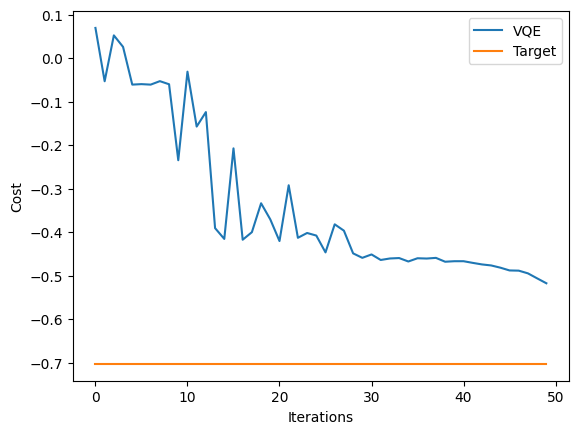

In [31]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 50)

# Define the constant function
constant = min(eigenvalues)
y_constant = np.full_like(x, constant)
ax.plot(
    range(cost_history_dict["iters"]), cost_history_dict["cost_history"], label="VQE"
)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.plot(y_constant, label="Target")
plt.legend()
plt.draw()

IBM Quantum has other upskilling offerings related to VQE. If you are ready to put VQE into practice, see our tutorial: [Ground-state energy estimation of the Heisenberg chain with VQE](/docs/tutorials/spin-chain-vqe). If you want more information on creating molecular Hamiltonians, see [this lesson](/learning/courses/quantum-chem-with-vqe/hamiltonian-construction) in our course on [Quantum chemistry with VQE](/learning/courses/quantum-chem-with-vqe). If you are interested in a deeper understanding of how variational algorithms like VQE work, we recommend the course [Variational Algorithm Design](/learning/courses/variational-algorithm-design/optimization-loops).

## 4. The strengths and weaknesses of VQE

Some strengths have already been pointed out. They include:

*   Suitability to modern hardware: Some quantum algorithms require much lower error rates, approaching large scale fault tolerance. VQE does not; it can be implemented on current quantum computers.
*   Shallow circuits: VQE often employs relatively shallow quantum circuits. This makes VQE less susceptible to accumulated gate errors and makes it suitable for many error mitigation techniques. Of course, the circuits are not always shallow; this depends on the ansatz used.
*   Versatility: VQE can (in principle) be applied to any problem that can be cast as an eigenvalue/eigenvector problem. There are many caveats that make VQE impractical or disadvantageous for some problems. Some of these are recapped below.

Some weaknesses of VQE and problems for which it is impractical have also been described above. These include:

*   Heuristic nature: VQE does not guarantee convergence to the correct ground state energy, as its performance depends on the choice of ansatz and optimization methods[\[1-2\]](#references). If a poor ansatz is chosen that lacks the requisite entanglement for the desired ground state, no classical optimizer can reach that ground state.
*   Potentially numerous parameters: A very expressive ansatz may have so many parameters that the minimization iterations are very time-consuming.
*   High measurement overhead: In VQE, an estimator is used to estimate the expectation value of each term in the Hamiltonian. Most Hamiltonians of interest will have terms that cannot be simultaneously estimated. This can make VQE resource-intensive for large systems with complicated Hamiltonians[\[1\]](#references).
*   Effects of noise: When the classical optimizer is searching for a minimum, noisy calculations can confuse it and steer it away from the true minimum or delay its convergence. One possible solution for this is leveraging state-of-the-art error mitigation and error suppression techniques[\[2-3\]](#references) from IBM.
*   Barren plateaus: These regions of vanishing gradients[\[2-3\]](#references) exist even in the absence of noise, but noise makes them more troublesome since the change in expectation values due to noise could be larger than the change from updating parameters in these barren regions.

## References

\[2] [https://en.wikipedia.org/wiki/Variational\_quantum\_eigensolver](https://en.wikipedia.org/wiki/Variational_quantum_eigensolver)

\[3] [https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.19.024047](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.19.024047)

\[4] [https://arxiv.org/abs/2111.05176](https://arxiv.org/abs/2111.05176)

\[6] [https://inquanto.quantinuum.com/tutorials/InQ\_tut\_fe4n2\_2.html](https://inquanto.quantinuum.com/tutorials/InQ_tut_fe4n2_2.html)

\[7] [https://www.nature.com/articles/s41467-019-10988-2](https://www.nature.com/articles/s41467-019-10988-2)

\[8] [https://arxiv.org/abs/2210.15438](https://arxiv.org/abs/2210.15438)

\[9] [https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013254](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013254)

\[10] [https://arxiv.org/html/2403.09624v1](https://arxiv.org/html/2403.09624v1)

\[11] [https://www.nature.com/articles/s42005-023-01312-y](https://www.nature.com/articles/s42005-023-01312-y)

\[13] [https://arxiv.org/abs/1802.00171](https://arxiv.org/abs/1802.00171)

\[14] [https://arxiv.org/abs/2103.08505](https://arxiv.org/abs/2103.08505)

\[15] [https://arxiv.org/html/2501.09702v1](https://arxiv.org/html/2501.09702v1)

\[16] [https://quri-sdk.qunasys.com/docs/examples/quri-algo-vm/qsci/](https://quri-sdk.qunasys.com/docs/examples/quri-algo-vm/qsci/)

\[17] [https://arxiv.org/abs/2412.13839](https://arxiv.org/abs/2412.13839)

\[18] [https://arxiv.org/abs/2302.11320v1](https://arxiv.org/abs/2302.11320v1)

\[19] [https://arxiv.org/pdf/2405.05068v1](https://arxiv.org/pdf/2405.05068v1)



© IBM Corp., 2017-2025